# How to use `while` loop

## Introduction
With the while loop we can execute a set of nodes as long as the condition is true. In this tutorial, you will learn how to use `while` loop in WorkTree.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow: while
Suppose we want to calculate:
```python
# start while block
n=1
while n < 100:
    n = n*2
    n = n + 3
# end while block
z = n+1
```

### Create node
We first create the nodes to do the calculation.

In [6]:
from aiida_worktree import node, WorkTree
from aiida.engine import calcfunction
from aiida.orm import Int, Bool

# we need a compare node for `n<100`
@node()
@calcfunction
def compare(x, y):
    return Bool(x < y)

# define multiply node for n*2
@node()
@calcfunction
def multiply(x, y):
    return x*y

# define add node for n+3
@node()
@calcfunction
def add(x, y):
    return x + y

# Create a WorkTree will repeat itself based on the conditions
# then we output the result of from the context (ctx)
@node.group(outputs = [["ctx", "n", "result"]])
def add_multiply_while(n, limit):
    wt = WorkTree("add_multiply_while")
    # tell the engine that this is a `while` worktree
    wt.is_while = True
    # the `result` of compares1 node is used as condition
    wt.conditions = [["compare1", "result"]]
    # set a context variable before running.
    wt.ctx = {"n": n}
    compare1 = wt.nodes.new(compare, name="compare1", x="{{n}}", y=Int(limit))
    multiply1 = wt.nodes.new(multiply, name="multiply1", x="{{ n }}", y=Int(2))
    add1 = wt.nodes.new(add, name="add1", y=3)
    # update the context variable
    add1.to_ctx = [["result", "n"]]
    wt.links.new(multiply1.outputs[0], add1.inputs[0])
    # don't forget to return the worktree
    return wt

### Create the workflow
Now, let'use the `add_multiply_while`  node in the workflow.

In [7]:
wt = WorkTree("test_while")
while1 = wt.nodes.new(add_multiply_while, n=Int(1), limit=50)
add1 = wt.nodes.new(add, y=Int(1))
wt.links.new(while1.outputs[0], add1.inputs[0])
wt.submit(wait=True)

[INFO] 2023-08-02 15:05:04 nodetree: Create NodeTree: test_while


### Check status and results


In [8]:
print("State of WorkTree:   {}".format(wt.state))
print('Result of add1   :   {}'.format(add1.node.outputs.result.value))

State of WorkTree:   FINISHED
Result of add1   :   62


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the worktree stops.

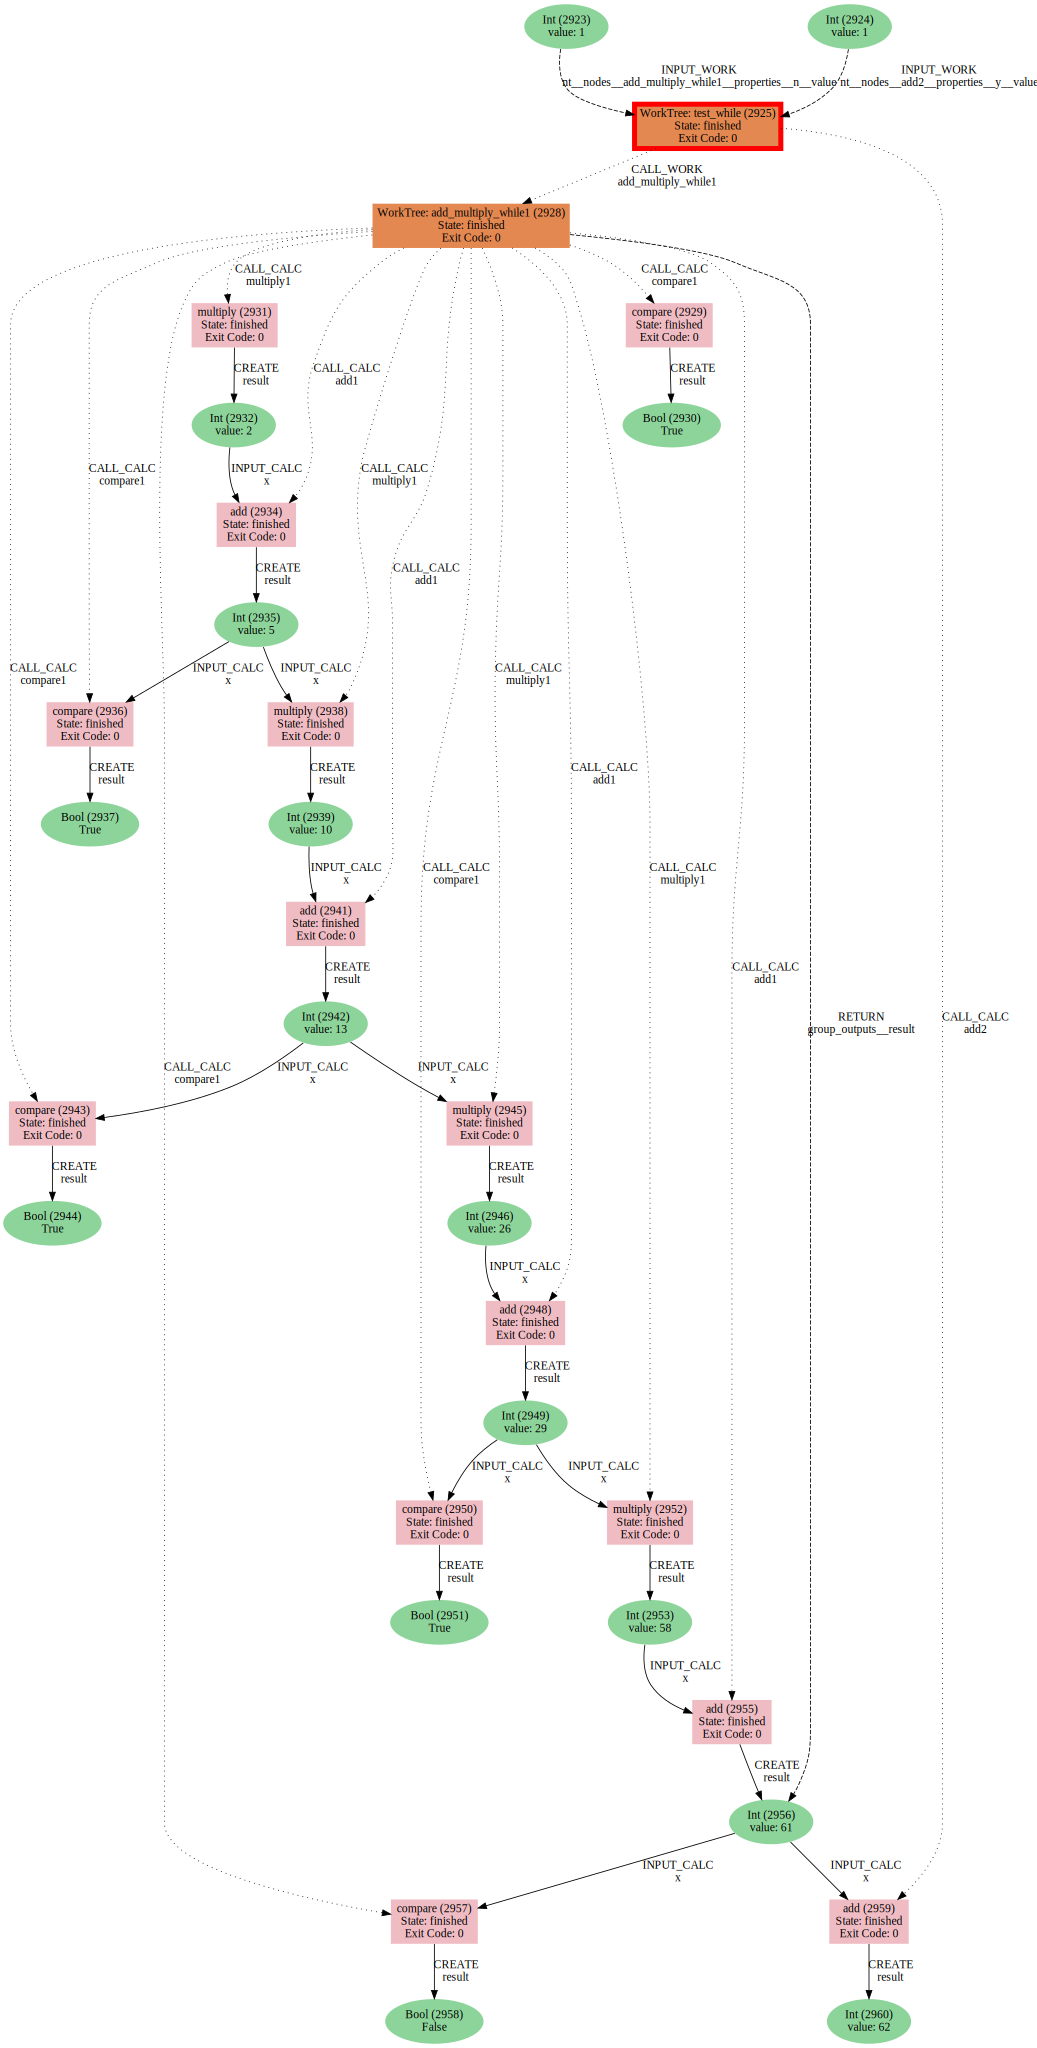

In [9]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)